In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd
from anndata import AnnData

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We can download the data easily from GEO:

In [2]:
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
!gzip -d -f counts.txt.gz

--2024-06-14 19:59:19--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1.5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1.50M  2.22MB/s    in 0.7s    

2024-06-14 19:59:20 (2.22 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]



We can visualize the different cell types in it:



In [3]:
# Read raw data and process it
adata = pd.read_csv('counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


In case your data does not contain gene symbols but rather gene ids like ENSMBL, you can use the function sc.queries.biomart_annotations to retrieve them. In this other vignette, ENSMBL ids are transformed into gene symbols.

The obtained data consist of raw read counts for six different samples (three controls, three treatments) for ~60k genes. Before continuing, we will transform our expression data into an AnnData object. It handles annotated data matrices efficiently in memory and on disk and is used in the scverse framework.

In [4]:
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


AnnData object with n_obs × n_vars = 6 × 64253

Inside an AnnData object, there is the .obs attribute where we can store the metadata of our samples. Here we will infer the metadata by processing the sample ids, but this could also be added from a separate dataframe:

In [5]:
# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


# Quality Control

To filter genes, we will follow the strategy implemented in the function filterByExpr from edgeR. It keeps genes that have a minimum total number of reads across samples (min_total_count), and that have a minimum number of counts in a number of samples (min_count).

We can plot how many genes do we keep, you can play with the min_count and min_total_count to check how many genes would be kept when changed:

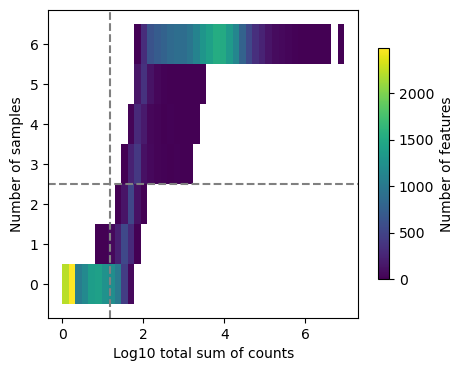

In [6]:
dc.plot_filter_by_expr(adata, group='condition', min_count=10, min_total_count=15, large_n=1, min_prop=1)


In [7]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group='condition', min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 6 × 19713
    obs: 'condition', 'sample_id'

## Differential expression analysis


In [8]:
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [9]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    inference=inference,
)

In [10]:
dds.deseq2()


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.43 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 36.05 seconds.

Fitting LFCs...
... done in 2.55 seconds.

Replacing 0 outlier genes.



In [11]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(
    dds,
    contrast=["condition", 'treatment', 'control'],
    inference=inference
)

In [12]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition treatment vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneName                                                                   
WASH7P           10.349783       -0.013826  0.588383 -0.023499  0.981252   
MIR6859-1        10.114621        0.056649  0.367074  0.154327  0.877352   
RP11-34P13.7     45.731312        0.075550  0.234376  0.322344  0.747192   
RP11-34P13.8     29.498381       -0.066700  0.357558 -0.186544  0.852018   
CICP27          106.032654        0.155742  0.175942  0.885185  0.376057   
...                    ...             ...       ...       ...       ...   
MT-ND6        17914.984375       -0.435304  0.274663 -1.584865  0.112997   
MT-TE          1281.293335       -0.332495  0.287943 -1.154723  0.248204   
MT-CYB        54955.449219       -0.313285  0.292679 -1.070406  0.284436   
MT-TT           204.692215       -0.483703  0.332233 -1.455916  0.145416   
MT-TP           345

... done in 1.32 seconds.



In [13]:
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
WASH7P,10.349783,-0.013826,0.588383,-0.023499,0.981252,0.986557
MIR6859-1,10.114621,0.056649,0.367074,0.154327,0.877352,0.916353
RP11-34P13.7,45.731312,0.075550,0.234376,0.322344,0.747192,0.819119
RP11-34P13.8,29.498381,-0.066700,0.357558,-0.186544,0.852018,0.898365
CICP27,106.032654,0.155742,0.175942,0.885185,0.376057,0.493753
...,...,...,...,...,...,...
MT-ND6,17914.984375,-0.435304,0.274663,-1.584865,0.112997,0.184565
MT-TE,1281.293335,-0.332495,0.287943,-1.154723,0.248204,0.354701
MT-CYB,54955.449219,-0.313285,0.292679,-1.070406,0.284436,0.396541


/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


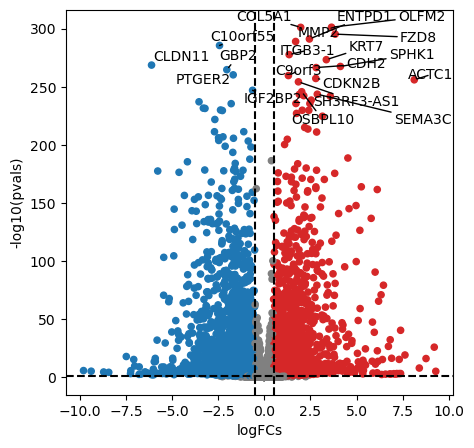

In [16]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(5, 5)
)

In [17]:
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName,WASH7P,MIR6859-1,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,-0.023499,0.154327,0.322344,-0.186544,0.885185,-2.193677,2.157392,-0.393217,-1.328259,-0.498827,...,-1.435491,0.60766,1.072015,0.777125,-1.243008,-1.584865,-1.154723,-1.070406,-1.455916,-2.333926


## Transcription factor activity inference


CollecTRI is a comprehensive resource containing a curated collection of TFs and their transcriptional targets compiled from 12 different resources. This collection provides an increased coverage of transcription factors and a superior performance in identifying perturbed TFs compared to our previous DoRothEA network and other literature based GRNs. Similar to DoRothEA, interactions are weighted by their mode of regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also available). We can use decoupler to retrieve it from omnipath. The argument split_complexes keeps complexes or splits them into subunits, by default we recommend to keep complexes together.

In [18]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


## Activity inference with Univariate Linear Model (ULM)


To infer TF enrichment scores we will run the Univariate Linear Model (ulm) method. For each sample in our dataset (mat) and each TF in our network (net), it fits a linear model that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

In [19]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 19713 targets for 655 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
treatment.vs.control,-1.673546,-1.652014,-1.254997,-2.493803,-2.557429,0.496793,-6.438168,1.296757,1.676963,-0.645493,...,-0.048419,2.621533,1.344819,-1.279542,-1.312388,-0.90866,0.255294,2.708296,0.680377,-2.224772


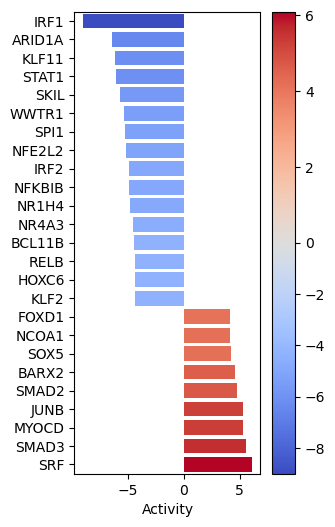

In [20]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='treatment.vs.control',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

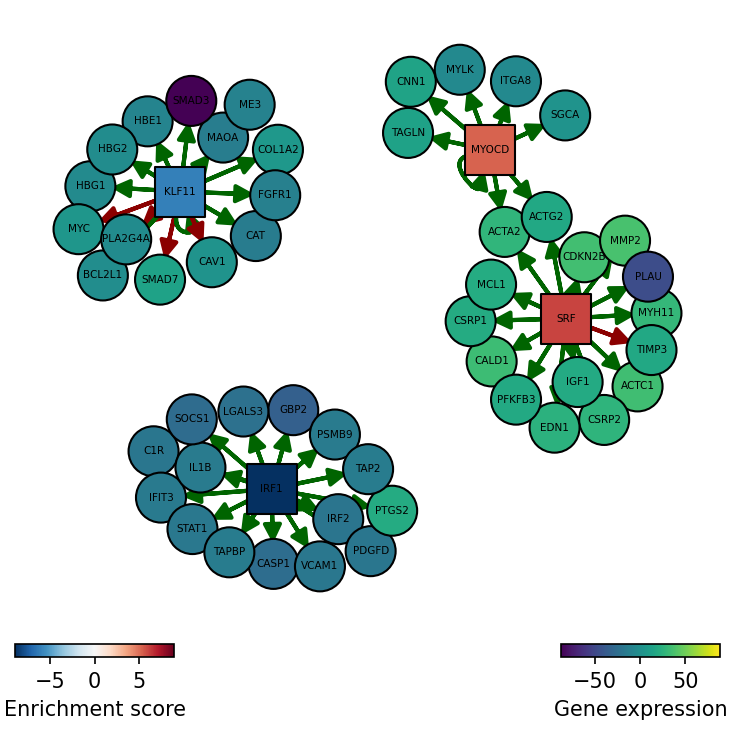

In [21]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['MYOCD', 'SRF', 'IRF1', 'KLF11'],
    n_targets=15,
    node_size=50,
    figsize=(5, 5),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True
)

/opt/conda/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


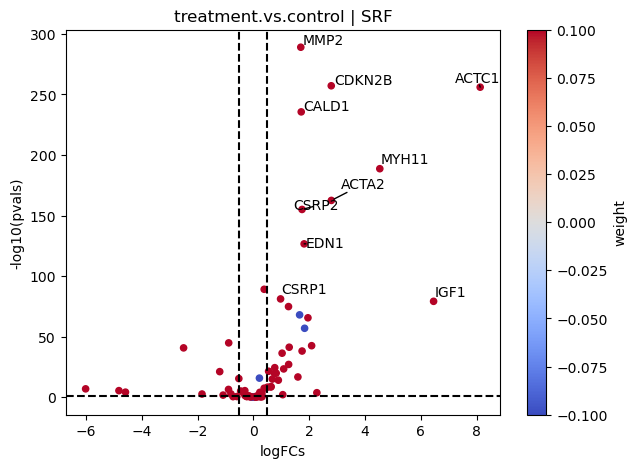

In [22]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(
    logFCs,
    pvals,
    'treatment.vs.control',
    name='SRF',
    net=collectri,
    top=10,
    sign_thr=0.05,
    lFCs_thr=0.5
)

## Pathway activity inference


PROGENy model
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

Androgen: involved in the growth and development of the male reproductive organs.

EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells

Estrogen: promotes the growth and development of the female reproductive organs.

Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.

JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.

MAPK: integrates external signals and promotes cell growth and proliferation.

NFkB: regulates immune response, cytokine production and cell survival.

p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.

PI3K: promotes growth and proliferation.

TGFb: involved in development, homeostasis, and repair of most tissues.

TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.

Trail: induces apoptosis.

VEGF: mediates angiogenesis, vascular permeability, and cell migration.

WNT: regulates organ morphogenesis during development and tissue repair.

To access it we can use decoupler.

In [27]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=1000)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
13995,p53,PABPC4,-2.282467,6.623818e-05
13996,p53,SF3B3,-1.615436,6.641896e-05
13997,p53,RNF26,-2.288269,6.643224e-05
13998,p53,RABL6,-1.156483,6.697673e-05


In [28]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 19713 targets for 14 sources.


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
treatment.vs.control,2.955833,-2.658006,5.040962,6.914194,-12.308722,10.123393,1.217688,11.384055,45.986717,-5.706391,-3.419871,4.730968,0.331011,-9.212416


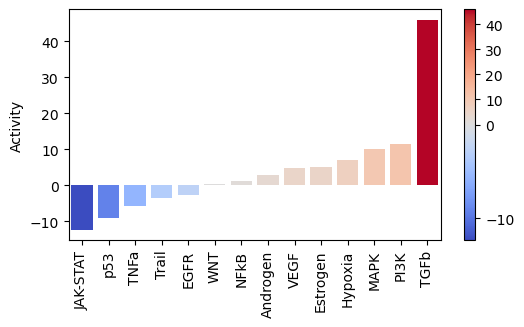

In [29]:
dc.plot_barplot(
    pathway_acts,
    'treatment.vs.control',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

We can visualize the targets of TFGb in a scatter plot:

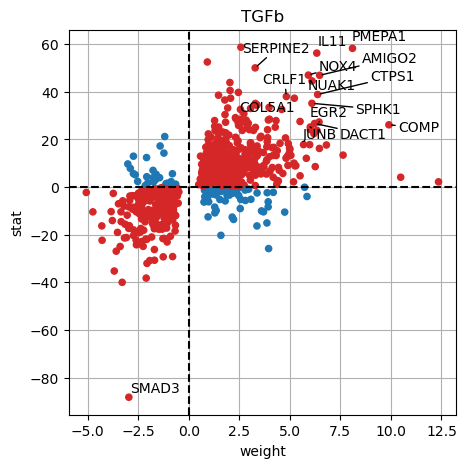

In [30]:
dc.plot_targets(results_df, stat='stat', source_name='TGFb', net=progeny, top=15)


## Functional enrichment of biological terms


### MSigDB gene sets
The Molecular Signatures Database (MSigDB) is a resource containing a collection of gene sets annotated to different biological processes.



In [31]:
msigdb = dc.get_resource('MSigDB')
msigdb

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [32]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


## Enrichment with Over Representation Analysis (ORA)


In [33]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.620000,0.000368,0.001535,1.246775,9.857531,ABCA1;ACAA2;ACADM;ACADS;ACLY;ACOX1;ADCY6;ADIPO...
1,ALLOGRAFT_REJECTION,200,0.380000,0.999747,1.000000,0.762380,0.000193,ABCE1;ABI1;APBB1;B2M;BCAT1;BCL10;BCL3;BRCA1;C2...
2,ANDROGEN_RESPONSE,100,0.610000,0.016738,0.038041,1.227056,5.018761,ABCC4;ABHD2;ACTN1;ADAMTS1;ALDH1A3;ANKH;ARID5B;...
3,ANGIOGENESIS,36,0.555556,0.305515,0.412858,1.125176,1.334185,COL3A1;CXCL6;FGFR1;FSTL1;ITGAV;JAG1;LRPAP1;NRP...
4,APICAL_JUNCTION,200,0.565000,0.035965,0.074927,1.135352,3.775283,ACTA1;ACTB;ACTC1;ACTG1;ACTG2;ACTN1;ACTN4;ADAM1...


* I did't fully undestood this one*

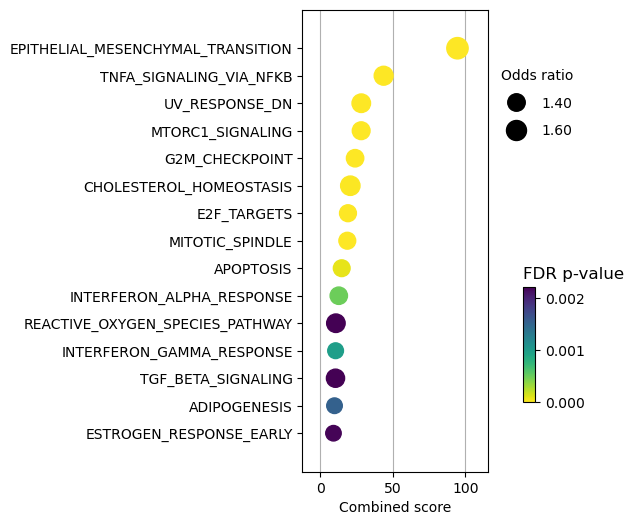

In [34]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=1.5,
    figsize=(3, 6)
)

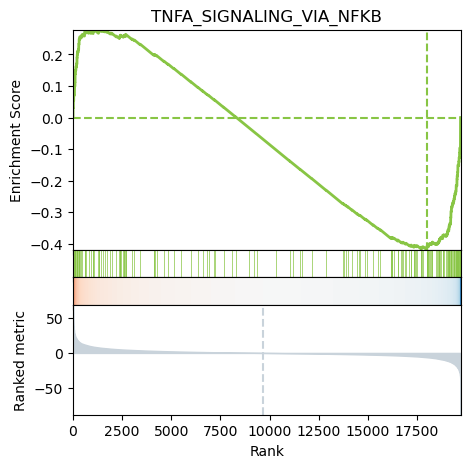

In [35]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='TNFA_SIGNALING_VIA_NFKB'
)

## Enrichment of ligand-receptor interactions


First, we extract ligand-receptor interactions from liana, and decomplexify them to format them into an appropriate decoupleR input.



In [36]:
import liana as ln

liana_lr = ln.resource.select_resource()
liana_lr = ln.resource.explode_complexes(liana_lr)

# Create two new DataFrames, each containing one of the pairs of columns to be concatenated
df1 = liana_lr[['interaction', 'ligand']]
df2 = liana_lr[['interaction', 'receptor']]

# Rename the columns in each new DataFrame
df1.columns = ['interaction', 'genes']
df2.columns = ['interaction', 'genes']

# Concatenate the two new DataFrames
liana_lr = pd.concat([df1, df2], axis=0)
liana_lr['weight'] = 1

# Find duplicated rows
duplicates = liana_lr.duplicated()

# Remove duplicated rows
liana_lr = liana_lr[~duplicates]

liana_lr

,interaction,genes,weight
0,LGALS9&PTPRC,LGALS9,1
1,LGALS9&MET,LGALS9,1
2,LGALS9&CD44,LGALS9,1
3,LGALS9&LRP1,LGALS9,1
4,LGALS9&CD47,LGALS9,1
...,...,...,...
5775,BMP2&ACTR2,ACTR2,1
5776,BMP15&ACTR2,ACTR2,1
5777,CSF1&CSF3R,CSF3R,1
5778,IL36G&IFNAR1,IFNAR1,1


Then we can use ulm to find the significant co-regulated pairs of ligand and receptors.



In [37]:
# Infer lr activities with ulm
lr_score, lr_pvalue = dc.run_ulm(
    mat=mat,
    net=liana_lr,
    source='interaction',
    target='genes',
    min_n=2,
    verbose=True
)

Running ulm on mat with 1 samples and 19713 targets for 2112 sources.


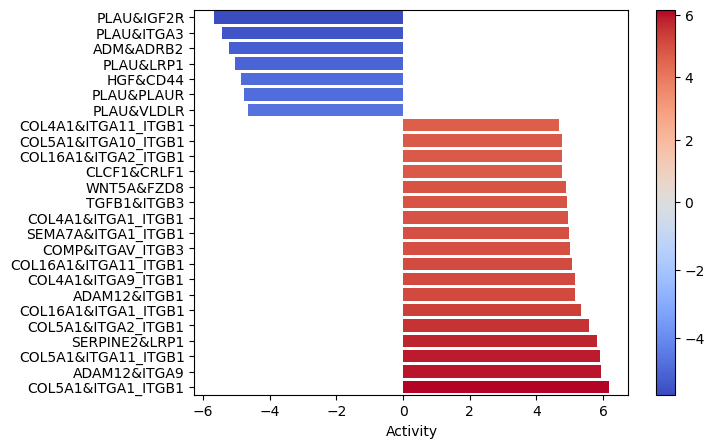

In [38]:
dc.plot_barplot(lr_score, 'treatment.vs.control', top=25, vertical=True)
